- 이미지 인식
    - 시각 피질 작동원리
        - 시각 인지 과정
            - 계층적으로 작동한다
            ㅊ
            - 뒤로 갈수록 복잡한 세포들은 조금 더 큰 영역의 이미지를 인식
        - 시각의 여러 세포들은 각자 다른 부분을 인지한다
            - 지형학적인 매필이 발생한다
            
            
            
- 이미지 데이터 -> 숫자로 전환 -> 컴퓨터는 숫자로 인식
    - 높이, 너비, 채널 -> 3차원 텐서로 구성
        - 높이 : 세로길이의 픽셀수
        - 너비 : 가로길이의 픽셀수
        - 채널 : 색의 성분
            - 흑백 : 채널수 1 -> 0 ~ 255
                - 칼라 : 채널수 3 -> Red, Green, Blue

- python에서 이미지 처리 
- Pillow를 사용
- Pillow 이전에는 PIL(python Image Library)이 패키지를 대체
    - JPEG, BPM, GIF, PNG, PPM, TIFF등 다양한 포맷 지원
    - PIL 패키지의 대체이므로 이름이 동일

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

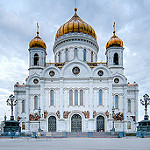

In [3]:
img = Image.open('./8.cnn_building.jpg')
img

In [4]:
import numpy as np

In [6]:
np.array( img ).shape, type(img), img.size # 사진 이미지의 기본 속성(데이터 크기 등)

((150, 150, 3), PIL.JpegImagePlugin.JpegImageFile, (150, 150))

In [8]:
#  (150, 150, 1) => 마지막 1(흑백)은 의미가 없어서 삭제
# 흑백 처리
img = img.convert( 'L' )
np.array( img ).shape, type(img), img.size


((150, 150), PIL.Image.Image, (150, 150))

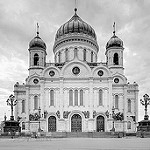

In [9]:
img

In [12]:
import torch

In [13]:
# 설정없어 float로 들어간다
img_tensor = torch.Tensor( np.array( img ) )
img_tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [213., 214., 215.,  ..., 196., 197., 198.],
        ...,
        [170., 170., 171.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 172., 174., 167.],
        [168., 168., 168.,  ..., 157., 158., 149.]])

- 합성곱 연산
    - 이미지 5x5, 커널 3x4, 셀 1x1 -> 결국 커널수에 맞춰서 나온다
<img src='./8.합성곱연산_모서리탐지.jpeg'>
- 작은 커널(kernel or filter or 가중치행렬)로 전체 이미지를 처음부터 끝까지 스캔하는 과정
- 5x5x1(1:흑백) 인 이미지를 3x3 커널로 1x1로 스캔(슬라이딩)하면 총 9번이 수행된다
    - (5-3+1) * (5-3+1) = 9
    - 이런 스캐닝을 슬라이딩이라고 정의

In [14]:
# 이미지 샘플
ex_img = np.array( [
    [13, 1,  2,  1,  2 ],
    [12, 15, 15, 1,  2 ],
    [1,  0,  15, 2,  1 ],
    [3,  2,  1,  12, 11],
    [2,  2,  3,  1,  10]
    
] )
ex_img_tensor = torch.Tensor( ex_img )
ex_img_tensor

tensor([[13.,  1.,  2.,  1.,  2.],
        [12., 15., 15.,  1.,  2.],
        [ 1.,  0., 15.,  2.,  1.],
        [ 3.,  2.,  1., 12., 11.],
        [ 2.,  2.,  3.,  1., 10.]])

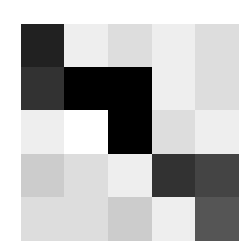

In [15]:
_, ax = plt.subplots(1,1)
ax.matshow(ex_img, cmap='binary')
ax.axis('off')
plt.show()

In [16]:
# 커널 3x3
kernel = torch.Tensor( [
    [ 1, 0, -1 ],
    [ 1, 0, -1 ],
    [ 1, 0, -1 ]
] )
kernel.size()

torch.Size([3, 3])

In [17]:
# ! (데이터가 몇개냐? = 1차원의 성분수, 2차원의 성분수)
kernel.size(0) # 0 -> 3줄 , 1 -> 3개 [[]]

3

In [29]:
# 합성곱 연산 구현
def convolution_operation( x_input, kernel ):
    # x의 크기 획득
    y, x    = x_input.size()
    # 커널의 사이즈 중 y축에 해당되는 값
    k_y, k_x = kernel.size() # 바로 위 ! code줄 참고, # k_y, k_x 두개 동시에 쓸 수 있는 이유는 정사각형이니깐.
    convs = []
    
    '''
    # 위의 그림에서 한개 점과 커널3x3을 곱해서 더하면 하나가 나온다 -> 하나 나온것이 총 9개가 나와야 한다
    for i in range( y-k_y+1 ):
        # 전체 데이터 크기에서 커널의 크기에 + 1 = 횟수는 3회
        # 구성요소 중, 같은 자리에 있는 원소끼리 (곱해서) 모두 더한다
        c = [ torch.sum(x_input[ i:i+k_y , j:j+k_x ] * kernel) for j in range(x-k_x+1) ] # 이중 for문 꼴
        convs.append( c )
    '''
    # 3x3에서 i번 밑으로 내려가는것, j번 옆으로 지나가는것을 표현한것 
    for i in range(y-k_y+1):
        c = []
        for j in range(x-k_x+1):
            # 합성곱
            c.append( torch.sum( x_input[i:i+k_y , j:j+k_x] * kernel ) ) # i: -> 가로 하나하나, j: -> 세로 하나하나  # 목표는 3x3을 만드는 것
            # 최대 풀링
            #c.append( torch.max( x_input[ i:i+k_y , j:j+k_x ] * kernel ) ) 
            # 최소 풀링
            #c.append( torch.min( x_input[ i:i+k_y , j:j+k_x ] * kernel ) )
        convs.append( c ) # 5x5 이 3x3으로 줄어든다 
    
    # 텐서화   
    return torch.Tensor( convs )
    
    
    
    
    

In [30]:
# 합성곱 주석 제거한 요약본
def convolution_operation( x_input, kernel ):
    y, x     = x_input.size()
    k_y, k_x = kernel.size()
    convs = []
    for i in range(y-k_y+1):
        c = []
        for j in range(x-k_x+1):
            c.append( torch.sum( x_input[i:i+k_y , j:j+k_x] * kernel ) ) 
        convs.append( c )
    return torch.Tensor( convs )
    
    
    

In [31]:
convs = convolution_operation( ex_img_tensor, kernel )
convs.size(), np.array( convs )

(torch.Size([3, 3]), array([[ -6.,  12.,  27.],
        [-15.,   2.,  17.],
        [-13., -11.,  -3.]], dtype=float32))

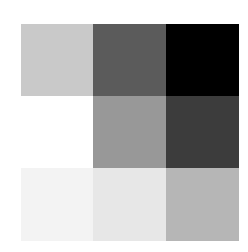

In [32]:
# 이미지가 합성곱층을 통과하여 만들어진 이미지 
_, ax = plt.subplots(1,1)
ax.matshow(convs, cmap='binary')
ax.axis('off')
plt.show()

In [33]:
# 지금 사용한 kernel이 수직 커널이다
# 샘플 이미지에 수직 커널을 적용해서 확인
vertical_convs = convolution_operation( img_tensor, kernel )

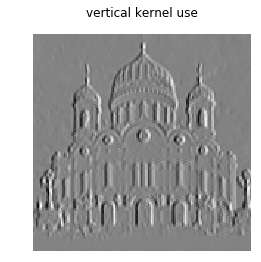

In [34]:
# 배경은 다 날리고 외곽선을 잡아준다
_, ax = plt.subplots(1,1)
ax.matshow(vertical_convs.numpy(), cmap='binary')
ax.axis('off')
ax.set_title('vertical kernel use')
plt.show()

In [35]:
# 수직커널을 수평 커널로 축을 회전시켜서 생성
# 수평커널
horizental_kernel = kernel.t() # 돌림(축회전)

In [36]:
horizental_kernel

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])

In [37]:
horizental_convs = convolution_operation( img_tensor, horizental_kernel )

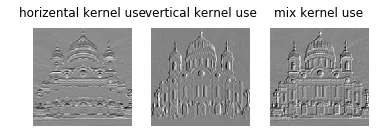

In [38]:
_, (ax1, ax2, ax3) = plt.subplots(1,3) # 한줄에 2칸 
ax1.matshow(horizental_convs.numpy(), cmap='binary')
ax1.axis('off')
ax1.set_title('horizental kernel use')

ax2.matshow(vertical_convs.numpy(), cmap='binary')
ax2.axis('off')
ax2.set_title('vertical kernel use')

ax3.matshow((vertical_convs+horizental_convs).numpy(), cmap='binary')
ax3.axis('off')
ax3.set_title('mix kernel use')

plt.show()